# MarNet - Custom CNN Model

### Import Necessary Libraries

In [ ]:
import os
import shutil
import glob
import json
from tensorflow.keras.optimizers import Adam
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from keras.applications import VGG16, ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Conv2DTranspose, concatenate, Flatten
import matplotlib.pyplot as plt
from scipy.io import loadmat
from tensorflow.keras.callbacks import EarlyStopping
import h5py
import cv2
import warnings
warnings.filterwarnings('ignore')
from google.colab import files
from google.colab import drive
from zipfile import ZipFile
from skimage.transform import resize

### Data Loading and Preparation

In [ ]:
# !pip install kaggle

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"martinsogiekpolor","key":"f12feca955857283a950ebe003fe016b"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!rm kaggle.json

In [ ]:
!kaggle datasets list

ref                                                              title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rahulvyasm/netflix-movies-and-tv-shows                           Netflix Movies and TV Shows                           1MB  2024-04-10 09:48:38           6783        136  1.0              
sujithmandala/second-hand-car-price-prediction                   Second Hand Car Price Prediction                      2KB  2024-04-24 12:09:30            830         24  1.0              
aniketmahajan1104/indian-cities-electricity-consumption-2017-19  Indian Cities Electricity Consumption 2017-19         2KB  2024-04-24 09:34:25            558         23  1.0              
mexwell/heart-disease-dataset                          

In [ ]:
!kaggle datasets download -d ashkhagan/figshare-brain-tumor-dataset --force

100% 836M/839M [00:22<00:00, 215MB/s]
100% 839M/839M [00:22<00:00, 38.8MB/s]


In [ ]:
image_paths = "/content/drive/MyDrive/Colab Notebooks/figshare-brain-tumor-dataset.zip"
extracted_folder_path = "/content/Tumor_Dataset"

with ZipFile(image_paths, 'r') as zip:
    zip.extractall(extracted_folder_path)
    print('Images extracted successfully.')


Images extracted successfully.


After extracting, merge all the data in each sub folder representing each class into one folder named Merged_Tumor_Dataset and delete any file without the expected file structure which is .mat format.  

In [ ]:
# Define the paths
extracted_folder_path = "/content/Tumor_Dataset"
merged_folder_path = "/content/Merged_Tumor_Dataset"

# Create the merged folder if it doesn't exist
if not os.path.exists(merged_folder_path):
    os.makedirs(merged_folder_path)

# Loop through all subdirectories and files
for root, dirs, files in os.walk(extracted_folder_path):
    for file in files:
        # Get the file path and move it to the merged folder
        file_path = os.path.join(root, file)
        shutil.move(file_path, merged_folder_path)

print("Files merged successfully!")

Files merged successfully!


In [ ]:
file = glob.glob('/content/Merged_Tumor_Dataset/*.mat')

In [ ]:
images = list()
masks = list()
class_labels = []
for fil in file:
    if os.path.isfile(fil):  # Check if it's a file
        with h5py.File(fil,'r') as f:
            try:
                lbl = np.array(f['cjdata']['label']).flatten()
                class_labels.extend(lbl)
                img = cv2.resize(np.array(f['cjdata']['image']), (128,128))
                mask = cv2.resize(np.array(f['cjdata']['tumorMask']), (128,128))
                images.append(img)
                masks.append(mask)
            except KeyError:
                os.remove(fil)  # Delete the file
                print(f"Error: File {fil} does not have the expected data structure and has been deleted.")
                continue

images = np.array(images)
masks = np.array(masks)

unique_class_labels = np.unique(class_labels)
print("Number of unique class labels:", len(unique_class_labels))
print("Number of images:", len(images))
print("Number of masks:", len(masks))

Error: File /content/Merged_Tumor_Dataset/cvind.mat does not have the expected data structure and has been deleted.
Number of unique class labels: 3
Number of images: 3064
Number of masks: 3064


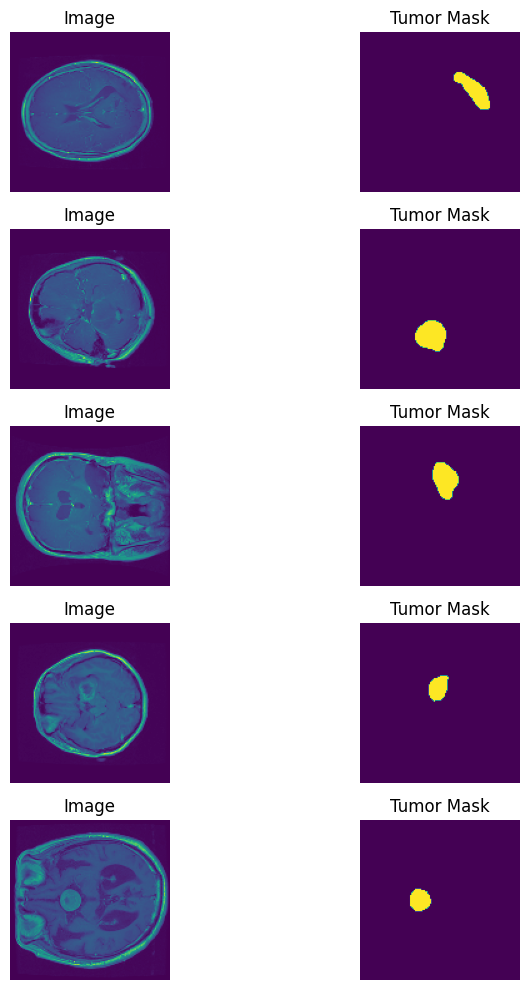

In [ ]:
# Visualize five samples
num_samples = 5
fig, axes = plt.subplots(num_samples, 2, figsize=(9, 2*num_samples))

for i in range(num_samples):
    sample_index = np.random.randint(len(images))

    # Plot image
    axes[i, 0].imshow(images[sample_index])
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')

    # Plot tumor mask
    axes[i, 1].imshow(masks[sample_index])
    axes[i, 1].set_title('Tumor Mask')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


#### Data Preparation for Custom CNN Model





In [ ]:
print('shape of masks:', masks.shape)
print('shape of images:', images.shape)

shape of masks: (3064, 128, 128)
shape of images: (3064, 128, 128)


In [ ]:

train_images, test_images, train_labels, test_labels = train_test_split(images, class_labels, test_size=0.3, random_state=42)

train_labels = np.array(train_labels) - 1
test_labels = np.array(test_labels) - 1

train_labels = to_categorical(train_labels, num_classes=3)
test_labels = to_categorical(test_labels, num_classes=3)

train_images = train_images / 255.0
test_images = test_images / 255.0



### Custom Model

In [ ]:
def DenseBlock(inp, name, max_pool=False):
    fp1 = layers.Conv2D(32, (3, 3), activation='relu', padding='SAME', name=name + '_Conv1')(inp)
    fp1 = layers.BatchNormalization(name=name + '_BatchNorm1')(fp1)
    fp1 = layers.Dropout(0.2, name=name + '_Dropout1')(fp1)
    con1 = layers.Concatenate(name=name + '_Concat1')([inp, fp1])

    fp2 = layers.Conv2D(32, (3, 3), activation='relu', padding='SAME', name=name + '_Conv2')(con1)
    fp2 = layers.BatchNormalization(name=name + '_BatchNorm2')(fp2)
    fp2 = layers.Dropout(0.2, name=name + '_Dropout2')(fp2)
    con2 = layers.Concatenate(name=name + '_Concat2')([inp, fp1, fp2])

    fp3 = layers.Conv2D(32, (3, 3), activation='relu', padding='SAME', name=name + '_Conv3')(con2)
    fp3 = layers.BatchNormalization(name=name + '_BatchNorm3')(fp3)
    fp3 = layers.Dropout(0.2, name=name + '_Dropout3')(fp3)
    con3 = layers.Concatenate(name=name + '_Concat3')([inp, fp1, fp2, fp3])

    fp4 = layers.Conv2D(32, (3, 3), activation='relu', padding='SAME', name=name + '_Conv4')(con3)
    fp4 = layers.BatchNormalization(name=name + '_BatchNorm4')(fp4)
    fp4 = layers.Dropout(0.2, name=name + '_Dropout4')(fp4)
    con4 = layers.Concatenate(name=name + '_Concat4')([inp, fp1, fp2, fp3, fp4])

    res = layers.Conv2D(32, (1, 1), activation='relu', padding='SAME', name=name + '_OutDense')(con4)
    res = layers.BatchNormalization(name=name + '_BatchNorm5')(res)

    if max_pool:
        max_p = layers.MaxPool2D(pool_size=(2, 2), name=name + '_Maxpool1')(res)
        return res, max_p
    return res

inp = layers.Input(shape=(128, 128, 1), name='InputLayer')
x = inp
skip = list()

for i in range(4):
    s, x = DenseBlock(x, 'Dense{0}'.format(i + 1), max_pool=True)
    skip.append(s)

x = layers.Conv2D(32, (3, 3), name='BottleNeck_Conv', padding='SAME')(x)
x = layers.BatchNormalization(name='BottleNeck_Normalization')(x)

for i in range(4):
    x = layers.UpSampling2D(size=(2, 2), name='Up-pool{0}'.format(i + 1))(x)
    x = layers.Concatenate(name='Concat{0}'.format(i + 1))([x, skip[-i - 1]])
    x = DenseBlock(x, 'Up_Dense{0}'.format(i + 1))

x = layers.Flatten(name='FlattenLayer')(x)
outp = layers.Dense(3, activation='softmax', name='OutputLayer')(x)
model = Model(inp, outp, name='Marnet')
model.summary()


Model: "Marnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputLayer (InputLayer)     [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 Dense1_Conv1 (Conv2D)       (None, 128, 128, 32)         320       ['InputLayer[0][0]']          
                                                                                                  
 Dense1_BatchNorm1 (BatchNo  (None, 128, 128, 32)         128       ['Dense1_Conv1[0][0]']        
 rmalization)                                                                                     
                                                                                                  
 Dense1_Dropout1 (Dropout)   (None, 128, 128, 32)         0         ['Dense1_BatchNorm1[0][0]

In [ ]:
best_model_path = "/content/drive/MyDrive/Colab Notebooks/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=best_model_path + "model/logs/", histogram_freq=1)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(best_model_path + 'model/weights/epoch_{0}.h5'.format('{epoch:03d}'))
model_best_callback = tf.keras.callbacks.ModelCheckpoint(best_model_path + 'best_model.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)

In [ ]:
Epochs = 25
Batch_size=32
num_folds = 10

In [ ]:
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_accuracy = []
fold_history = []
best_accuracy = 0.0

for fold, (train_index, val_index) in enumerate(kf.split(train_images)):
    print(f"Fold {fold + 1}/{num_folds}")
    X_train, X_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=Epochs,
                        batch_size=Batch_size,
                        workers=1,
                        use_multiprocessing=False,
                        shuffle=True,
                        callbacks=[tensorboard_callback, model_checkpoint_callback, model_best_callback, early_stopping])

    fold_history.append(history.history)

    # Save the best model
    val_accuracy = history.history['val_accuracy'][-1]
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        model.save(best_model_path)

# Load the best model and test on the test data
model.load_weights(best_model_path)
loss, accuracy = model.evaluate(test_images, test_labels)
print(f'Test Loss: {loss:.3f}')
print(f'Test Accuracy: {accuracy:.3f}')

Fold 1/10
Epoch 1/25
61/61 [==============================] - 61s 317ms/step - loss: 5.8562 - accuracy: 0.6817 - val_loss: 9.2197 - val_accuracy: 0.5721
Epoch 2/25
61/61 [==============================] - 10s 163ms/step - loss: 4.1435 - accuracy: 0.8154 - val_loss: 20.6049 - val_accuracy: 0.4372
Epoch 3/25
61/61 [==============================] - 11s 180ms/step - loss: 2.7233 - accuracy: 0.8756 - val_loss: 6.2511 - val_accuracy: 0.6791
Epoch 4/25
61/61 [==============================] - 11s 181ms/step - loss: 1.1615 - accuracy: 0.9316 - val_loss: 5.6739 - val_accuracy: 0.7116
Epoch 5/25
61/61 [==============================] - 9s 155ms/step - loss: 1.1454 - accuracy: 0.9445 - val_loss: 23.0986 - val_accuracy: 0.4000
Epoch 6/25
61/61 [==============================] - 10s 164ms/step - loss: 0.8254 - accuracy: 0.9580 - val_loss: 9.3247 - val_accuracy: 0.7163
Epoch 7/25
61/61 [==============================] - 11s 181ms/step - loss: 0.6080 - accuracy: 0.9684 - val_loss: 4.0194 - val_accur

29/29 [==============================] - 2s 25ms/step


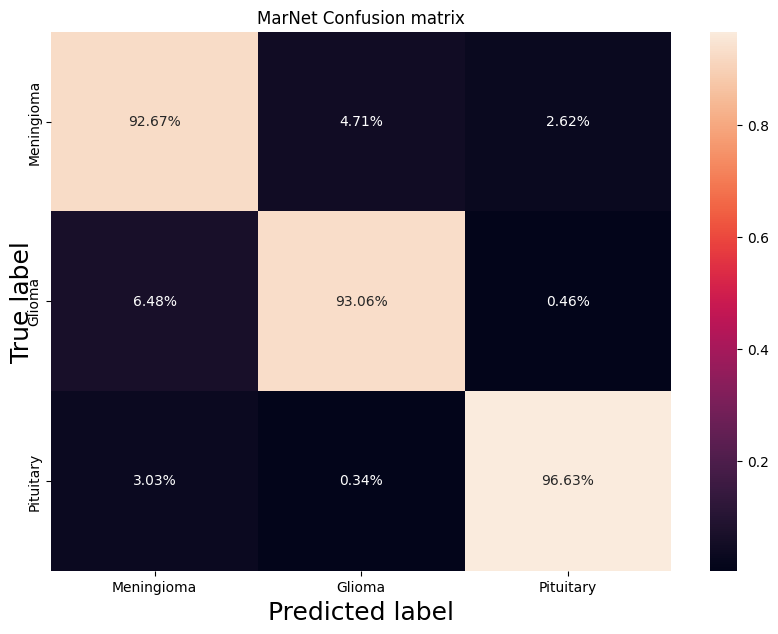

In [ ]:
# Load the best model and test on the test data
model.load_weights(best_model_path)
y_hat = model.predict(test_images)
y_hat = np.argmax(y_hat, axis=-1)
y = np.argmax(test_labels, axis=-1)

# Print the custom confusion matrix
nCM = confusion_matrix(y.flatten(), y_hat.flatten(), normalize='true')
# nCM = np.pad(nCM, ((0, 1), (0, 1)), mode='constant')
df_cm = pd.DataFrame(nCM, index = ['Meningioma', 'Glioma', 'Pituitary'], columns = ['Meningioma', 'Glioma', 'Pituitary'])
plt.figure(figsize = (10,7))
plt.title('MarNet Confusion matrix')
sn.heatmap(df_cm, annot=True, fmt='.2%')
plt.xlabel('Predicted label', fontsize=18)
plt.ylabel('True label',va='center', fontsize=18)
plt.savefig('ConfusionMat.png')
plt.show()


In [ ]:
# Print the classification report
print(classification_report(y.flatten(), y_hat.flatten(), target_names=['Meningioma', 'Glioma', 'Pituitary']))

              precision    recall  f1-score   support

  Meningioma       0.83      0.93      0.87       191
      Glioma       0.98      0.93      0.95       432
   Pituitary       0.98      0.97      0.97       297

    accuracy                           0.94       920
   macro avg       0.93      0.94      0.93       920
weighted avg       0.95      0.94      0.94       920



### Baseline Models

#### Data Preparation for Baseline Models.

ResNet50 and VGG16 takes RGB Images only so we convert our greyscale images.

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(images, class_labels, test_size=0.3, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.3, random_state=42)


In [ ]:
train_labels = np.array(train_labels) - 1
val_labels = np.array(val_labels) - 1
test_labels = np.array(test_labels) - 1

train_labels = to_categorical(train_labels, num_classes=3)
val_labels = to_categorical(val_labels, num_classes=3)
test_labels = to_categorical(test_labels, num_classes=3)

train_images = np.expand_dims(train_images, axis=-1)
train_images = np.repeat(train_images, 3, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)
test_images = np.repeat(test_images, 3, axis=-1)
val_images = np.expand_dims(val_images, axis=-1)
val_images = np.repeat(val_images, 3, axis=-1)

train_images = train_images / 255.0
test_images = test_images / 255.0
val_images = val_images / 255.0


In [ ]:
epochs = 25
batch_size = 32
num_classes = 3
input_shape = (128, 128, 3)

### VGG16

In [ ]:
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
x_vgg16 = Conv2D(3, (3, 3), activation='relu', padding='same')(base_model_vgg16.input)

# Add custom top layers for VGG16
x_vgg16 = base_model_vgg16.output
x_vgg16 = GlobalAveragePooling2D()(x_vgg16)
x_vgg16 = Dense(512, activation='relu')(x_vgg16)
predictions_vgg16 = Dense(num_classes, activation='softmax')(x_vgg16)

model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions_vgg16)

model_vgg16.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history_vgg16 = model_vgg16.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(val_images, val_labels))

58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/25
47/47 [==============================] - 11s 91ms/step - loss: 1.4928 - accuracy: 0.5053 - val_loss: 1.0634 - val_accuracy: 0.4814
Epoch 2/25
47/47 [==============================] - 1s 27ms/step - loss: 0.8925 - accuracy: 0.5773 - val_loss: 0.8222 - val_accuracy: 0.6242
Epoch 3/25
47/47 [==============================] - 1s 27ms/step - loss: 0.7883 - accuracy: 0.6273 - val_loss: 0.8369 - val_accuracy: 0.5575
Epoch 4/25
47/47 [==============================] - 1s 27ms/step - loss: 0.7030 - accuracy: 0.6693 - val_loss: 0.5823 - val_accuracy: 0.7298
Epoch 5/25
47/47 [==============================] - 1s 27ms/step - loss: 0.6317 - accuracy: 0.7187 - val_loss: 0.6404 - val_accuracy: 0.6770
Epoch 6/25
47/47 [==============================] - 1s 27ms/step - loss: 0.6049 - accuracy: 0.7293 - val_loss: 0.5190 - val_accuracy: 0.7811
Epoch 7/25
47/47 [==============================] - 1s 27ms/step - loss: 0.4890 - accura

In [ ]:
score_vgg16 = model_vgg16.evaluate(test_images, test_labels, verbose=0)
print("VGG16 Test Loss:", score_vgg16[0])
print("VGG16 Test Accuracy:", score_vgg16[1])

VGG16 Test Loss: 0.27051296830177307
VGG16 Test Accuracy: 0.8902173638343811


29/29 [==============================] - 0s 8ms/step


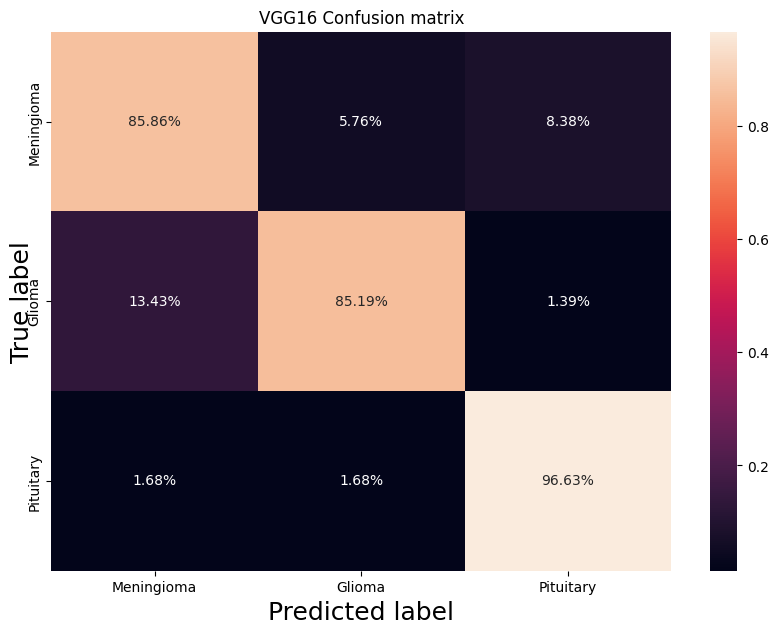

In [ ]:
y_hat_vgg16 = model_vgg16.predict(test_images)
y_hat_vgg16_class = np.argmax(y_hat_vgg16, axis=1)
nCM_vgg16 = confusion_matrix(np.argmax(test_labels, axis=1), y_hat_vgg16_class, normalize='true')
df_cm_vgg16 = pd.DataFrame(nCM_vgg16, index = ['Meningioma', 'Glioma', 'Pituitary'], columns = ['Meningioma', 'Glioma', 'Pituitary'])
plt.figure(figsize = (10,7))
plt.title('VGG16 Confusion matrix')
sn.heatmap(df_cm_vgg16, annot=True, fmt='.2%')
plt.xlabel('Predicted label', fontsize=18)
plt.ylabel('True label',va='center', fontsize=18)
plt.savefig('VGG16_ConfusionMat.png')
plt.show()



In [ ]:
print("VGG16 Classification Report:")
print(classification_report(np.argmax(test_labels, axis=1), y_hat_vgg16_class, target_names=['Meningioma', 'Glioma', 'Pituitary']))


VGG16 Classification Report:
              precision    recall  f1-score   support

  Meningioma       0.72      0.86      0.78       191
      Glioma       0.96      0.85      0.90       432
   Pituitary       0.93      0.97      0.95       297

    accuracy                           0.89       920
   macro avg       0.87      0.89      0.88       920
weighted avg       0.90      0.89      0.89       920



### ResNet50

In [ ]:
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
x_resnet50 = Conv2D(3, (3, 3), activation='relu', padding='same')(base_model_resnet50.input)


# Add custom top layers for ResNet50
x_resnet50 = base_model_resnet50.output
x_resnet50 = GlobalAveragePooling2D()(x_resnet50)
x_resnet50 = Dense(512, activation='relu')(x_resnet50)
predictions_resnet50 = Dense(num_classes, activation='softmax')(x_resnet50)

model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=predictions_resnet50)

model_resnet50.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet50 = model_resnet50.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(val_images, val_labels))

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/25
47/47 [==============================] - 36s 128ms/step - loss: 0.6082 - accuracy: 0.8000 - val_loss: 4.1149 - val_accuracy: 0.5637
Epoch 2/25
47/47 [==============================] - 2s 46ms/step - loss: 0.2990 - accuracy: 0.8960 - val_loss: 4.8206 - val_accuracy: 0.6537
Epoch 3/25
47/47 [==============================] - 2s 46ms/step - loss: 0.1709 - accuracy: 0.9347 - val_loss: 6.2461 - val_accuracy: 0.3525
Epoch 4/25
47/47 [==============================] - 2s 47ms/step - loss: 0.1470 - accuracy: 0.9500 - val_loss: 7.6840 - val_accuracy: 0.3727
Epoch 5/25
47/47 [==============================] - 2s 46ms/step - loss: 0.1891 - accuracy: 0.9287 - val_loss: 2.0516 - val_accuracy: 0.6102
Epoch 6/25
47/47 [==============================] - 2s 47ms/step - loss: 0.0659 - accuracy: 0.9760 - val_loss: 0.8629 - val_accuracy: 0.7655
Epoch 7/25
47/47 [==============================] - 2s 48ms/step - loss: 0.0748 - accur

In [ ]:
score_resnet50 = model_resnet50.evaluate(test_images, test_labels, verbose=0)
print("ResNet50 Test Loss:", score_resnet50[0])
print("ResNet50 Test Accuracy:", score_resnet50[1])

ResNet50 Test Loss: 0.541303813457489
ResNet50 Test Accuracy: 0.8673912882804871


29/29 [==============================] - 1s 9ms/step


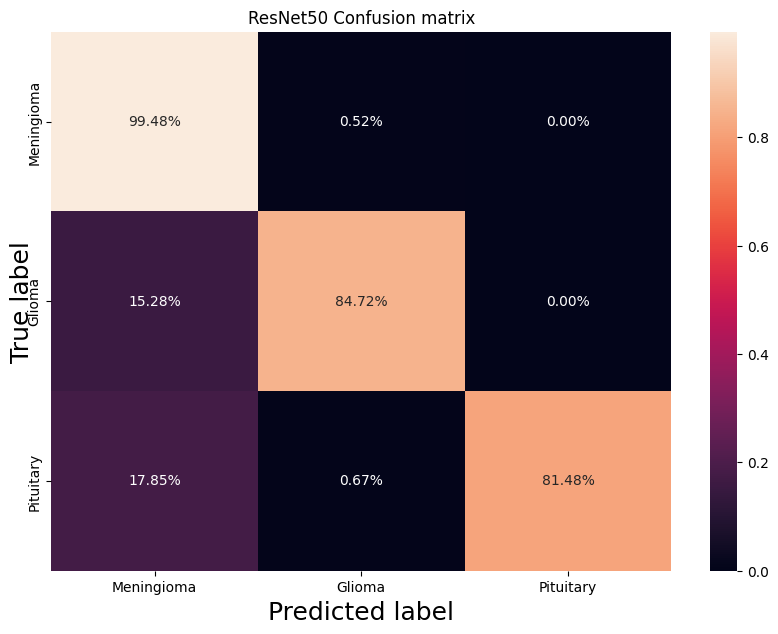

In [ ]:
y_hat_resnet50 = model_resnet50.predict(test_images)
y_hat_resnet50_class = np.argmax(y_hat_resnet50, axis=1)
nCM_resnet50 = confusion_matrix(np.argmax(test_labels, axis=1), y_hat_resnet50_class, normalize='true')
df_cm_resnet50 = pd.DataFrame(nCM_resnet50, index = ['Meningioma', 'Glioma', 'Pituitary'], columns = ['Meningioma', 'Glioma', 'Pituitary'])
plt.figure(figsize = (10,7))
plt.title('ResNet50 Confusion matrix')
sn.heatmap(df_cm_resnet50, annot=True, fmt='.2%')
plt.xlabel('Predicted label', fontsize=18)
plt.ylabel('True label',va='center', fontsize=18)
plt.savefig('ResNet50_ConfusionMat.png')
plt.show()



In [ ]:
print("ResNet50 Classification Report:")
print(classification_report(np.argmax(test_labels, axis=1), y_hat_resnet50_class, target_names=['Meningioma', 'Glioma', 'Pituitary']))


ResNet50 Classification Report:
              precision    recall  f1-score   support

  Meningioma       0.61      0.99      0.76       191
      Glioma       0.99      0.85      0.91       432
   Pituitary       1.00      0.81      0.90       297

    accuracy                           0.87       920
   macro avg       0.87      0.89      0.86       920
weighted avg       0.92      0.87      0.88       920

